In [10]:
import numpy as np

from utils import *
from core import *
import imageio.v3 as iio
from PIL import Image

im = iio.imread('../assets/800px-SheppLogan.png')

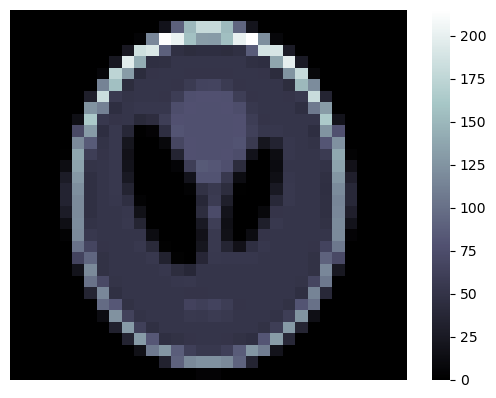

In [11]:
# loading image
new_res = 32

img = Image.fromarray(im).resize((new_res, new_res))
img = np.array(img.convert('L'))
plot_image(img, cmap='bone')

In [12]:
A = CreateInterceptMatrix(
  no_of_detectors=new_res,
  source_to_object=20,
  source_to_detector=42,
  size_of_object=12,
  no_of_rotations=new_res,
  angle_bw_detectors=0.01652,
  resolution=new_res
).create_intercept_matrix_from_lines()

## Forward Problem

solving the forward problem of obtaining detector readings using image matrix (shepp Logan)

In [13]:
b = A @ img.flatten()
b.shape

(1024,)

## Backward Problem

In [14]:
A_pinv = pinv(A, num_iterations=200)

Performing decomposition:  96%|█████████▌| 982/1024 [01:01<00:02, 15.97it/s]


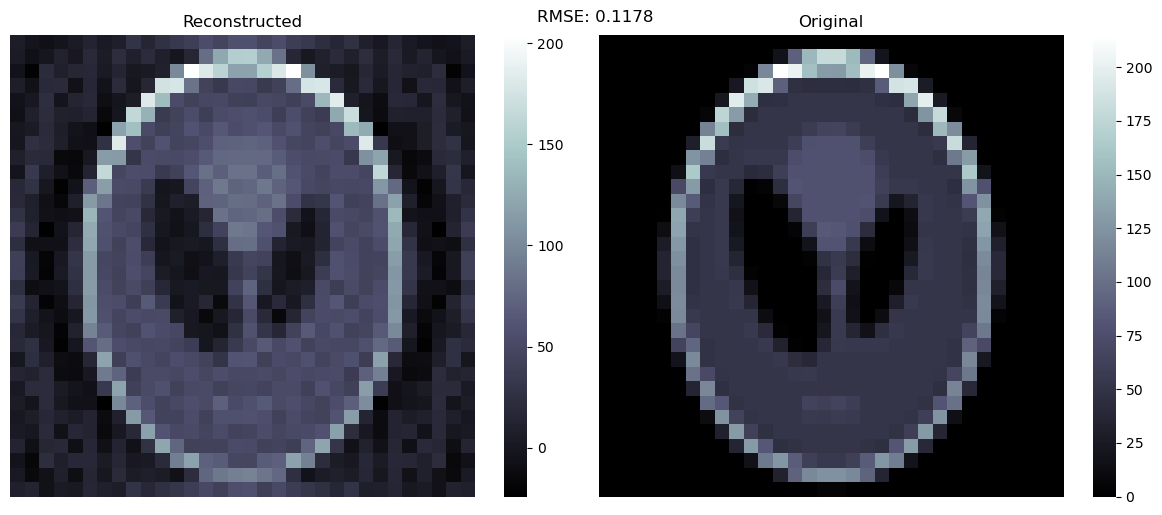

In [35]:
A_pinv_rounded = np.round(A_pinv, 4)
x = A_pinv_rounded @ b
plot_images(x.reshape(new_res, -1), img, cmap='bone')